<a href="https://colab.research.google.com/github/Sawnann/colab-test/blob/main/2.%20MODEL5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Conv1D
tf.random.set_seed(0)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [6]:
from google.colab import files

# 打開檔案選擇器並上傳檔案
uploaded = files.upload()

# 列出上傳的檔案
for filename in uploaded.keys():
    print(f"已上傳的檔案: {filename}")

Saving beer.csv to beer (1).csv
已上傳的檔案: beer (1).csv


In [ ]:
df = pd.read_csv('beer.csv')
#print(df.head(3))
#print('size of dataset:', len(df))

In [7]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace= True)

In [8]:
# Plot the Series to see Trend and Seasonality
'''from matplotlib import pyplot as plt
f = plt.figure()
f.set_figwidth(13)
f.set_figheight(5)
plt.plot(df['deg'], linewidth = 3, label = "Original Series")
plt.legend(fontsize=18, loc='best', shadow=True)
plt.xlabel('Year', fontsize = 22)
plt.ylabel('Count', fontsize = 22)'''

'from matplotlib import pyplot as plt\nf = plt.figure()\nf.set_figwidth(13)\nf.set_figheight(5)\nplt.plot(df[\'deg\'], linewidth = 3, label = "Original Series")\nplt.legend(fontsize=18, loc=\'best\', shadow=True)\nplt.xlabel(\'Year\', fontsize = 22)\nplt.ylabel(\'Count\', fontsize = 22)'

elec
plt.ylim(14000,28000)
plt.yticks([15000,20000,25000])

temp
plt.ylim(10,35)
plt.yticks([10,20,30])

beer
plt.ylim(50,230)
plt.yticks([50,100,150,200])

plt.show()

In [9]:
# Convert it into a Sequence to Sequence Prediction Problem
def Tranform_dataset(input_length, output_length, data):
    df = data.copy()

    #input columns creation
    i = 0
    while i < input_length:
        df[f'x_{i}'] = df['deg'].shift(-i)
        i = i + 1

    #output columns creations
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['deg'].shift(-output_length-j)
        j = j + 1

    #drop some of the last columns
    df = df.dropna(axis=0)

    return df

In [10]:
history = 6 #last values used by model
future = 6 #predict future values

In [11]:
#轉換資料型態 將history(12筆特徵值(x)+6筆標籤答案(y)變成一筆row data來訓練
full_data = Tranform_dataset(history, future, df)
print(len(full_data))
print(full_data.head(3))

465
             deg   x_0   x_1   x_2   x_3   x_4   x_5   y_0    y_1    y_2  \
Month                                                                      
1956-01-01  93.2  93.2  96.0  95.2  77.1  70.9  64.8  70.1   77.3   79.5   
1956-02-01  96.0  96.0  95.2  77.1  70.9  64.8  70.1  77.3   79.5  100.6   
1956-03-01  95.2  95.2  77.1  70.9  64.8  70.1  77.3  79.5  100.6  100.7   

              y_3    y_4    y_5  
Month                            
1956-01-01  100.6  100.7  107.1  
1956-02-01  100.7  107.1   95.9  
1956-03-01  107.1   95.9   82.8  


In [12]:
#用x及y做區分去input及output
X_cols = [col for col in full_data.columns if col.startswith('x')]
y_cols = [col for col in full_data.columns if col.startswith('y')]

In [13]:
X = full_data[X_cols].values
y = full_data[y_cols].values
print(X.shape, y.shape)

(465, 6) (465, 6)


In [14]:
#資料訓練的分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [15]:
X_train = X_train.reshape(X_train.shape[0], history, 1)
X_test = X_test.reshape(X_test.shape[0], history, 1)
print(X_train.shape, X_test.shape)

(372, 6, 1) (93, 6, 1)


In [16]:
# Study Two Different LSTM Model
def get_model_cnn_lstm(history, future):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(LSTM(16, return_sequences=True, activation='relu'))
    model.add(LSTM(16, return_sequences=False, activation='relu'))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model_cnnlstm = get_model_cnn_lstm(history, future)
model_cnnlstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 16)               │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4, 16)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,390 (17.15 KB)

 Trainable params: 4,390 (17.15 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 打開檔案選擇器並上傳檔案
uploaded = files.upload()

# 列出上傳的檔案
for filename in uploaded.keys():
    print(f"已上傳的檔案: {filename}")


Saving CNN_LSTM.hdf5 to CNN_LSTM.hdf5
已上傳的檔案: CNN_LSTM.hdf5


In [18]:
filepath = 'CNN_LSTM.keras'
checkpoint_cnn_lstm = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')
callbacks_cnn_lstm = [checkpoint_cnn_lstm]

In [19]:
hist_cnn_lstm = model_cnnlstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(X_test, y_test),
                 shuffle=True, callbacks = callbacks_cnn_lstm)

Epoch 1/50
12/12 - 5s - 408ms/step - loss: 18785.0488 - val_loss: 24527.1934
Epoch 2/50
12/12 - 0s - 14ms/step - loss: 18644.1953 - val_loss: 24339.8926
Epoch 3/50
12/12 - 0s - 25ms/step - loss: 18246.2070 - val_loss: 22753.7637
Epoch 4/50
12/12 - 0s - 23ms/step - loss: 13301.3320 - val_loss: 13031.7441
Epoch 5/50
12/12 - 0s - 16ms/step - loss: 7791.9717 - val_loss: 7010.9995
Epoch 6/50
12/12 - 0s - 13ms/step - loss: 3956.9917 - val_loss: 3021.7480
Epoch 7/50
12/12 - 0s - 16ms/step - loss: 1695.5773 - val_loss: 1517.1090
Epoch 8/50
12/12 - 0s - 22ms/step - loss: 986.2560 - val_loss: 1048.4320
Epoch 9/50
12/12 - 0s - 24ms/step - loss: 740.5242 - val_loss: 859.2290
Epoch 10/50
12/12 - 0s - 12ms/step - loss: 632.5648 - val_loss: 778.1943
Epoch 11/50
12/12 - 0s - 15ms/step - loss: 598.6496 - val_loss: 755.6730
Epoch 12/50
12/12 - 0s - 13ms/step - loss: 588.2084 - val_loss: 751.3056
Epoch 13/50
12/12 - 0s - 10ms/step - loss: 581.4637 - val_loss: 754.0953
Epoch 14/50
12/12 - 0s - 11ms/step -

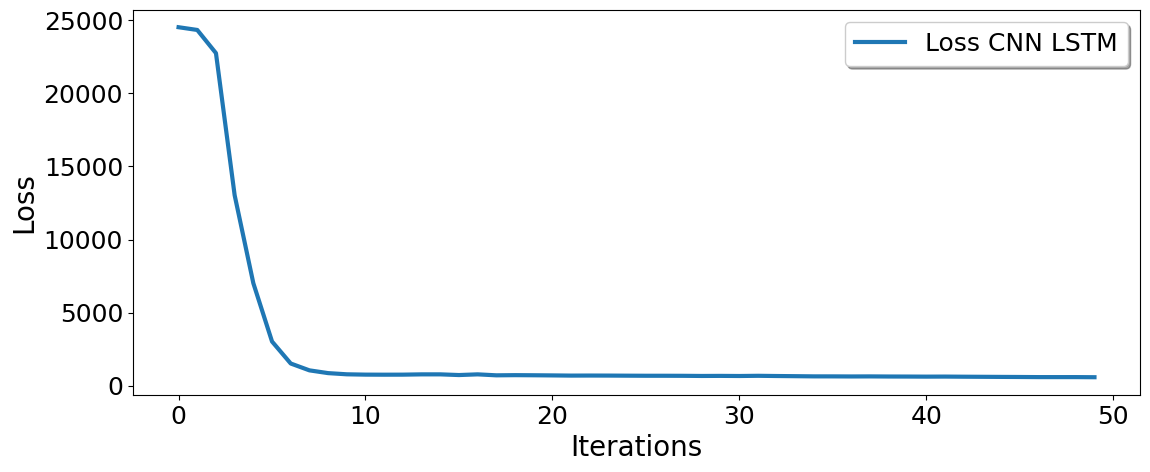

In [20]:
#indicate training loss(LSTM_CNN)
fig = plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 18})
plt.plot(hist_cnn_lstm.history['val_loss'], label = "Loss CNN LSTM", lw=3)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize = 18, loc='best', shadow=True)
plt.show()

In [21]:
# Get predictions on all the data
model_cnnlstm.load_weights('CNN_LSTM.keras')
y_pred_cnn_lstm = model_cnnlstm.predict(X.reshape(X.shape[0], history, 1))
pred_cnn_lstm = []
truth = []

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
for i in range(len(y_pred_cnn_lstm)):
    if i==(len(y_pred_cnn_lstm)-1):
        for j in range(len(y_pred_cnn_lstm[i])):
            pred_cnn_lstm.append(y_pred_cnn_lstm[i][j])
            truth.append(y[i][j])
    else:
        pred_cnn_lstm.append(y_pred_cnn_lstm[i][0])
        truth.append(y[i][0])

In [ ]:
# F9
fig= plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 18})

<Figure size 1300x500 with 0 Axes>

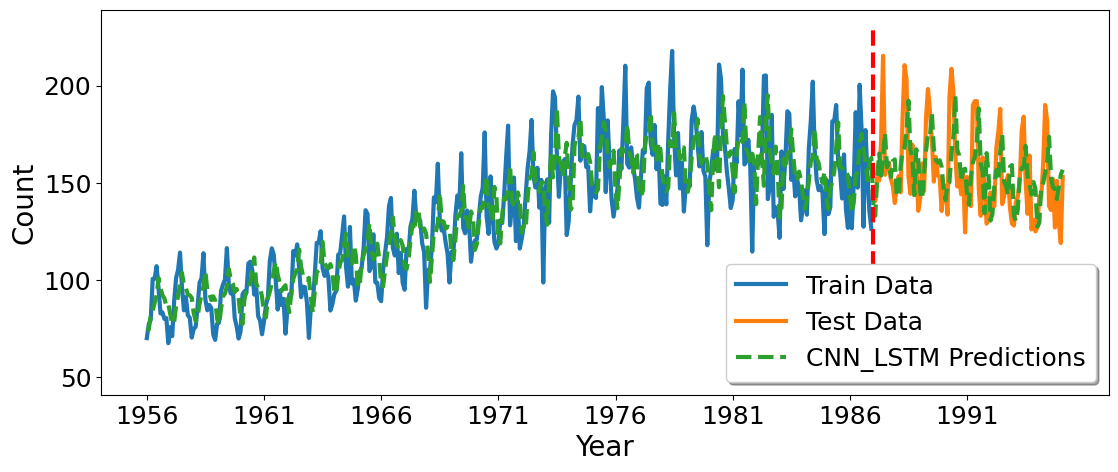

In [ ]:
fig= plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 18})
months = [i for i in range(len(truth))]
years= df.index
year_starts = [i for i in range(0, len(truth), 60)] #elec:24; temp:120; beer:60;
year_labels = [str(years[i].year) for i in year_starts]
plt.plot(months[0:len(y_train)], truth[0:len(y_train)],label='Train Data', lw=3)
plt.plot(months[len(y_train):], truth[len(y_train):],label='Test Data', lw=3)
plt.plot(pred_cnn_lstm,label='CNN_LSTM Predictions', lw=3, linestyle='dashed')
#elec
# plt.vlines(x=len(y_train), ymin= 12000, ymax = 28000, lw=3, linestyle='dashed', color='r')
#temp
# plt.vlines(x=len(y_train), ymin= 5, ymax = 35, lw=3, linestyle='dashed', color='r')
#beer
plt.vlines(x=len(y_train), ymin= 50, ymax = 230, lw=3, linestyle='dashed', color='r')
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xticks(year_starts, year_labels)
plt.legend(fontsize = 18, loc='lower right', shadow=True)
plt.show()

In [ ]:
#績效
mae = mean_absolute_error(truth[len(y_train):], pred_cnn_lstm[-98:]) # 44; 145; 93
mse = mean_squared_error(truth[len(y_train):], pred_cnn_lstm[-98:])
mape = mean_absolute_percentage_error(truth[len(y_train):], pred_cnn_lstm[-98:])

In [ ]:
print(f"Mean squared error: {mse:.4f}")
print(f"Mean absolute error: {mae:.4f}")
print(f"Mean absolute percentage error: {mape:.4f}")

Mean squared error: 415.3440
Mean absolute error: 16.6835
Mean absolute percentage error: 0.1074
